# Introduzione

L'obiettivo è quello di analizzare il dataset sui funghi, e testare diversi classificatori per trovare il migliore nel classificare nuovi funghi come commestibili o velenosi. Il documento è composto come segue:

- Data Exploration
    - Analisi classi dataset
    - Feature Selection
    - Rimozione righe malformate
- Test Classificatori
    - Naive Bayes
    - Random Forest
    - ...
    - ...

Import delle librerie necessarie

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
#altri import futuri

Caricamento del dataset

In [3]:
dataset = pd.read_csv("dataset/dataset.csv", sep=",")
dataset_bak = dataset
dataset.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


## Class Balancing

Siamo interessati a classificare i funghi come velenosi o meno, per questo motivo identifichiamo le due classi di interesse a partire dalla colonna "class" del dataset. Vogliamo vedere quanto sono bilanciate le classi del dataset

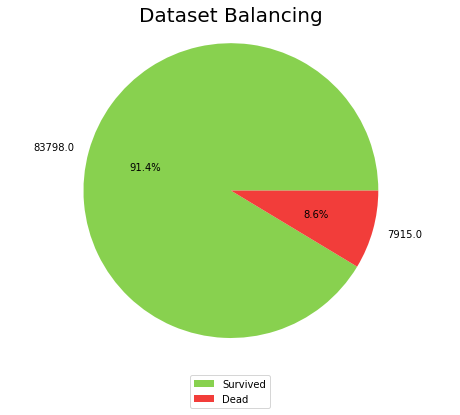

In [4]:
classes = [{"Survived": (dataset["hospital_death"] == 0).sum(), "Dead": (dataset["hospital_death"] == 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Vediamo come il dataset sia fortemente sbilanciato, avendo il 91% di classi 'survived' e soltanto il 9% di classi 'death'. Ciò vuol dire che i modelli utilizzati tenderanno maggiormente a classificare un paziente come in grado di sopravvivere, anziché in pericolo di vita. Per questo è necessario effettuare un bilanciamento del dataset. Le possibilità sono:

- Undersampling
- Oversampling
- SMOTE

La scelta è ricaduta sull'undersampling in quanto oversampling e SMOTE introdurrebbero un rumore eccessivo nel dataset, dovendo introdurre circa 74000 istanze artificiali. 

### Undersampling

Visualizziamo la distribuzione delle features.

In [5]:
dataset.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Unnamed: 83,hospital_death
count,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,88993.000000,...,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,0.0,91713.000000
mean,65606.079280,65537.131464,105.669262,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,84.028340,...,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,0.086302
std,37795.088538,37811.252183,62.854406,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,25.011497,...,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,0.280811
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,38.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,32852.000000,32830.000000,47.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,66.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
50%,65665.000000,65413.000000,109.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,80.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
75%,98342.000000,98298.000000,161.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,97.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
max,131051.000000,131051.000000,204.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,186.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000


Vediamo che ci sono in percetuale il 10% in più di funghi velenosi, e questo può portare il classificatore a tendere nel classificare funghi come velenosi (falso positivo). Questo errore è meno grave del falso negativo (perche se ti dico che un fungo è velenoso comunque non lo mangi, il contrario invece è velenoso ti dico di no e muori). 

Possiamo pensare di ribilanciare le classi tramite oversampling o undersampling, oppure ancora meglio con SMOTE.

Rivalutare magari il class balancing dopo rimozione delle righe con valori nulli.

## Visualizzazione campi non nulli

Visualizzazione campi non nulli per ogni colonna/feature del dataset. Questo ci serve per vedere eventuali colonne che possono poi essere rimosse

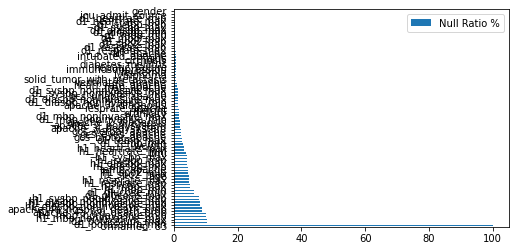

['Unnamed: 83']

In [6]:
def plot_nas(training_X: pd.DataFrame, threshold, use_treshold):
    to_delete = []
    if training_X.isnull().sum().sum() != 0:
        na_training_X = (training_X.isnull().sum() / len(training_X)) * 100
        na_training_X = na_training_X.drop(na_training_X[na_training_X == 0].index).sort_values(ascending=False)
        to_delete = na_training_X[na_training_X > threshold]

        missing_data = pd.DataFrame({'Null Ratio %' :na_training_X})
        missing_data.plot(kind = "barh")
        plt.rcParams['figure.figsize'] = (20,50)

        if use_treshold:
            plt.axvline(x=50, color='red')
            plt.text(45,-1,'thr = 50', color = 'red')
        plt.show()
        
    else:
        print('No NAs found')
    return to_delete.index.tolist()
        

plot_nas(dataset,50,False)

Analizzando la distribuzione delle varie features è evidente che la feature ```veil-type``` possa essere rimossa dall'insieme delle features. Questo perché presenta soltanto 3177 valori non nulli, e di valore costante ```u```.
La features verrà eliminata automaticamente dall'applicazione della VarianceThreshold

## Conversione Features e Mapping

Conversione delle features categoriche in nominali, si modifica prima il tipo di dato dei valori delle features da ```object``` in ```category``` per poi procedere con l'effettiva trasformazione dei valori categorici.

Si trasformano i valori categorici in numerici (int64) e si salva il dizionario che mantiene il mapping per un eventuale utilizzo futuro.

In [7]:
dataset = pd.read_csv("dataset/dataset.csv", sep=",")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [8]:
# from sklearn.preprocessing import OneHotEncoder
# categ =[]
# for col in dataset:
#     if (dataset[col].dtype == 'object'):
#         categ.append(col)

# # integer encode
mapped_dataset = dataset.copy()
encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(dataset['ethnicity'])

# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

# print(integer_encoded)
mapping = []
for i in range(len(mapped_dataset.columns)):
    
    if (mapped_dataset[mapped_dataset.columns[i]].dtype == "object"):

            mapped_dataset[mapped_dataset.columns[i]] = encoder.fit_transform(mapped_dataset[mapped_dataset.columns[i]])
            mapping_dict = {index : label for index , label in enumerate(encoder.classes_)}
            mapping.append(mapping_dict)

mapped_dataset = mapped_dataset.where(~dataset.isna(), dataset)
mapping


[{0: 'African American',
  1: 'Asian',
  2: 'Caucasian',
  3: 'Hispanic',
  4: 'Native American',
  5: 'Other/Unknown',
  6: nan},
 {0: 'F', 1: 'M', 2: nan},
 {0: 'Accident & Emergency',
  1: 'Floor',
  2: 'Operating Room / Recovery',
  3: 'Other Hospital',
  4: 'Other ICU',
  5: nan},
 {0: 'admit', 1: 'readmit', 2: 'transfer'},
 {0: 'CCU-CTICU',
  1: 'CSICU',
  2: 'CTICU',
  3: 'Cardiac ICU',
  4: 'MICU',
  5: 'Med-Surg ICU',
  6: 'Neuro ICU',
  7: 'SICU'},
 {0: 'Cardiovascular',
  1: 'Gastrointestinal',
  2: 'Genitourinary',
  3: 'Gynecological',
  4: 'Hematological',
  5: 'Metabolic',
  6: 'Musculoskeletal/Skin',
  7: 'Neurological',
  8: 'Respiratory',
  9: 'Sepsis',
  10: 'Trauma',
  11: nan},
 {0: 'Cardiovascular',
  1: 'Gastrointestinal',
  2: 'Haematologic',
  3: 'Metabolic',
  4: 'Neurologic',
  5: 'Renal/Genitourinary',
  6: 'Respiratory',
  7: 'Trauma',
  8: 'Undefined Diagnoses',
  9: 'Undefined diagnoses',
  10: nan}]

In [9]:
mapped_dataset.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,2,1,180.3,1,...,1.0,0.0,0.0,0.0,0.0,0.0,9,0,NaN,0
1,114252,59342,81,77.0,27.42,0,2,0,160.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,8,6,NaN,0
2,119783,50777,118,25.0,31.95,0,2,0,172.7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,3,NaN,0
3,79267,46918,118,81.0,22.64,1,2,0,165.1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,NaN,0
4,92056,34377,33,19.0,NaN,0,2,1,188.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,7,NaN,0


Completiamo trasformando il tipo di dato associato alle features categoriche da ```object``` in ```float64```, oggetto che accetta valori interi nulli.

In [10]:
for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('float64')

Vediamo che abbiamo mappato le nostre variabili categoriche in variabili ordinali. I valori nulli sono stati mantenuti <NaN> per una successiva fase di imputazione. 

In [11]:
mapped_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  float64
 7   gender                         91688 non-null  float64
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  float64
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  int32  
 12  icu_type                       91713 non-null 

## Feature Correlation

Vediamo il grado di correlazione reciproco tra le varie feature, compresa la correlazione di ogni feature con il target. In generale vogliamo che una feature sia altamente correlata con il target (quindi che il suo valore sia importante per discriminare se il fungo è positivo o negativo). Una correlazione alta è sia positiva (aumento del valore di uno aumenta il valore dell'altro) che negativa (aumento del valore di uno diminuisce il valore dell'altro). Una correlazione vicina allo zero implica che le variabili sono indipendenti tra loro.

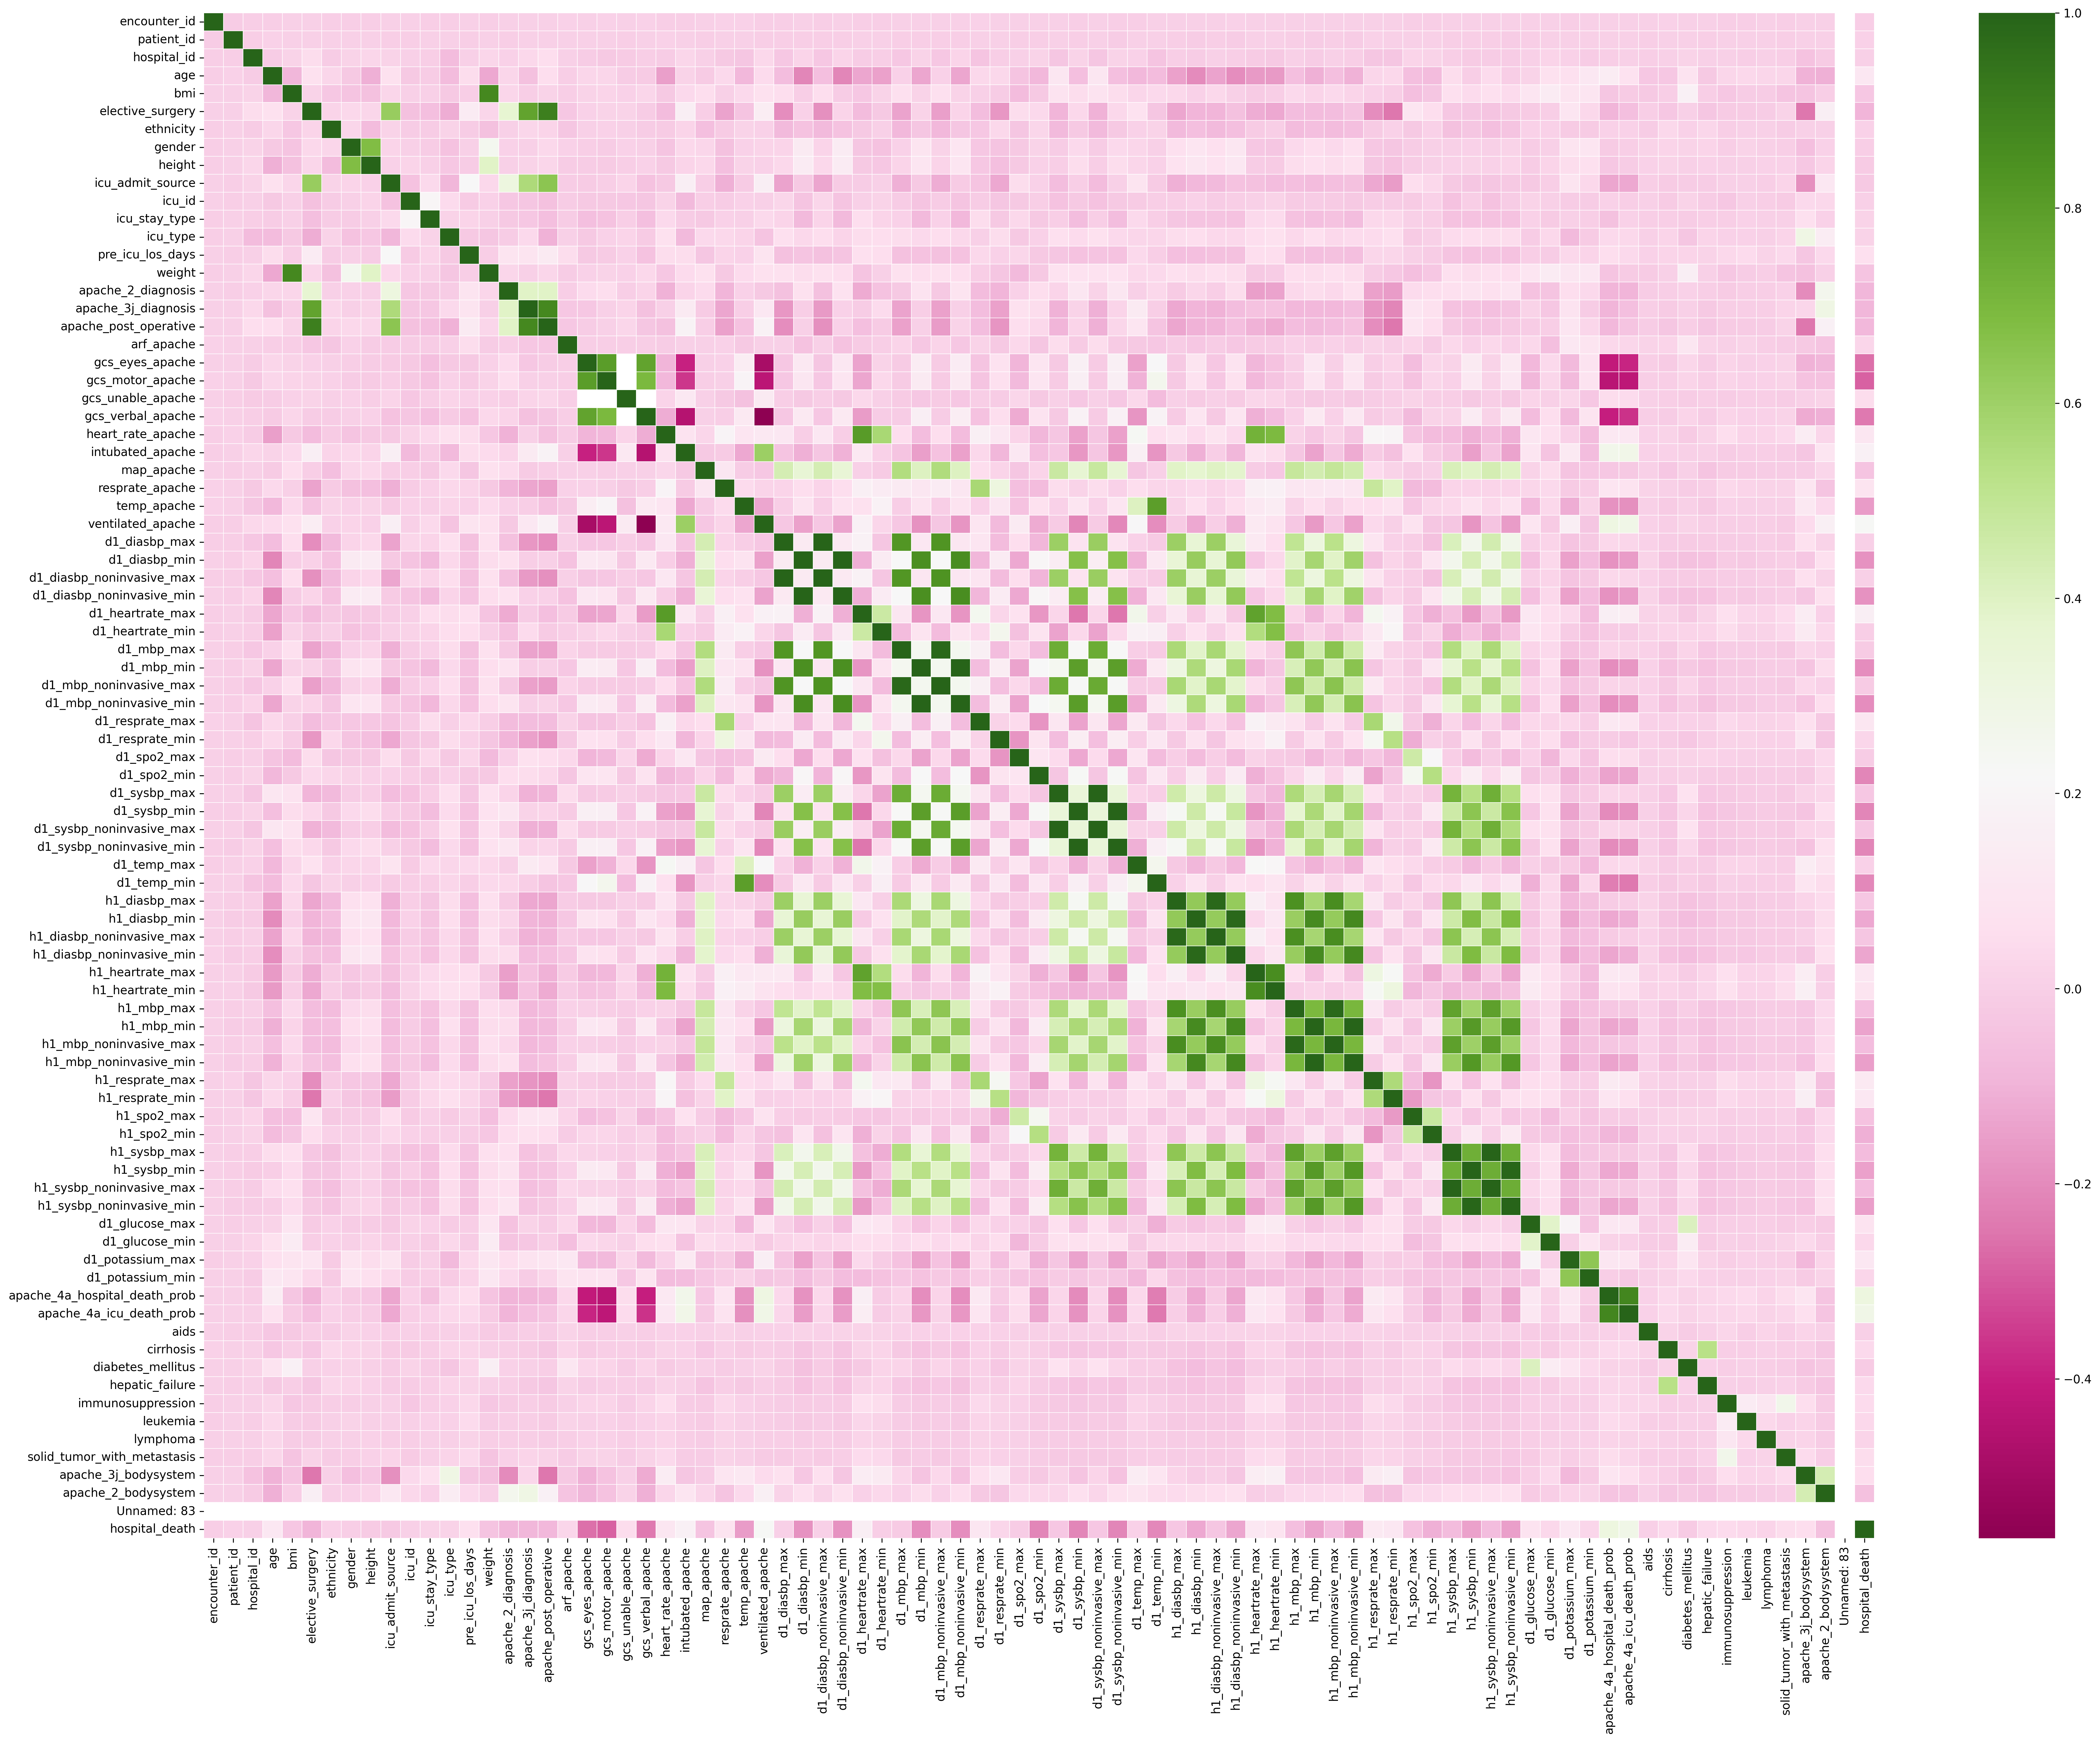

In [12]:
plt.figure(figsize=(32,24), dpi=300)
correlation_matrix = mapped_dataset.corr()
sns.heatmap(correlation_matrix, linewidths=0.05, cmap="PiYG")
plt.yticks(rotation=0)
plt.show()

# Training Set Cleaning

Andiamo a splittare il dataset in training e stesting set


## Feature Selection

Si selezionano le feature più utili ai fini della classificazione

### Rimozione di features con dati costanti

Primo approccio base di feature selection andiamo a rimuovere le feature con varianza nulla presenti nel training_X, ovvero quelle features il cui valore è costante.   
Dalla fase di Data Visualization abbiamo notato che una features con varianza nulla è il veil-type.
 
Applicando una Variance Threshold pari al 20% vengono rimosse le features ```does-bruise-or-bleed```, ```has-ring``` e ```veil-type```
  
TODO rivalutare dopo se abbassandola migliora la classificazione 

### Rimozione di features con valori nulli

Si cancellano le features che presentano più del 50% di valori nulli. Per le colonne con meno del 50% di valori nulli si utilizza invece un meccanismo di imputazione per sopperire alla presenza di dati mancanti in quelle features da scartare ma che hanno buona correlazione (vd. dopo) con la variabile target e buona distribuzione dei valori.

Tra queste features con 50% valori nulli controlliamo la correlazione con la variabile target perché features con pochi valori, ma comunque significativi nella discriminazione con la classe possono migliorare 

- Otteniamo la lista di features che superano la soglia del 50%

- Verifichiamo quali tra queste features hanno una correlazione bassa con il target

# Classificazione
Sono stati analizzati i risultati ottenuti dai seguenti modelli:
* Naive Bayes
* 

In [13]:
targets = mapped_dataset['hospital_death']
trainX, testX, trainY, testY = train_test_split(mapped_dataset.drop(columns = 'hospital_death'), targets, test_size = 0.2, random_state=0)
print("TrainingSet: {}".format(trainX.shape))
print("TestingSet: {}".format(testX.shape))


TrainingSet: (73370, 84)
TestingSet: (18343, 84)


Visualizziamo il balancing del training set

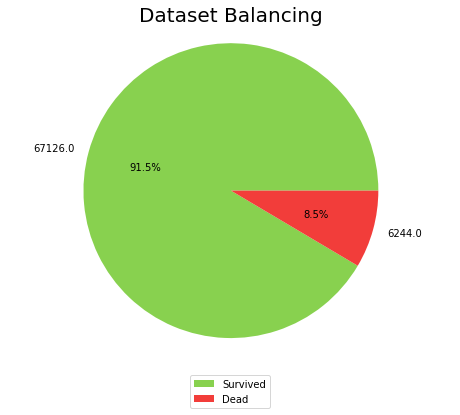

In [14]:
classes = [{"Survived": (trainY== 0).sum(), "Dead": (trainY== 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Proviamo a bilanciare

In [15]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

num_survd = (trainY== 0).sum()
num_death = (trainY== 1).sum()

num_under = num_survd - num_death
print (num_under)

rus = RandomOverSampler(random_state=0)
#trainX,trainY = rus.fit_resample(trainX.fillna(-1),trainY.fillna(-1))

60882


Vediamo dai risultati che peggiorano tutte le metriche applicando il balancing.

In [16]:
# TODO

Prova con feature selection

In [17]:
import statsmodels.api as sm

Selected_Features = []


def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")
    
    
backward_regression(trainX.fillna(-1), trainY)

worst_feature : h1_resprate_max, 0.982672274714517 
worst_feature : d1_sysbp_noninvasive_min, 0.9776880422162391 
worst_feature : hospital_id, 0.9471681344577604 
worst_feature : d1_mbp_noninvasive_max, 0.8676112498548518 
worst_feature : h1_diasbp_min, 0.7929662272933105 
worst_feature : apache_post_operative, 0.7494265300246278 
worst_feature : h1_diasbp_noninvasive_max, 0.6912687985482697 
worst_feature : weight, 0.6407035816383588 
worst_feature : h1_sysbp_min, 0.5668616359324998 
worst_feature : icu_id, 0.5084454257326312 
worst_feature : d1_diasbp_noninvasive_min, 0.47801619162947473 
worst_feature : d1_mbp_noninvasive_min, 0.5878984479598239 
worst_feature : patient_id, 0.39251308876877167 
worst_feature : d1_sysbp_max, 0.3379637246085163 
worst_feature : d1_mbp_max, 0.39830971179886754 
worst_feature : h1_mbp_max, 0.12287876210864901 
worst_feature : h1_mbp_min, 0.5243353676230278 
worst_feature : h1_mbp_noninvasive_max, 0.4921099361754345 
worst_feature : h1_sysbp_noninvasive_

Tiene solo le features selezionate

In [22]:
trainX_f = trainX.loc[:, Selected_Features[0]]
testX_f = testX.loc[:, Selected_Features[0]]

trainX_f.shape

(73370, 64)

Vediamo i risultati base ottenuti dai classificatori considerati nel training set originale. Utilizzeremo questi per vedere se e come l'ingegneria delle features ed il cleaning del dataset permettono di migliorare la qualità del dataset e quindi del modello.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# TODO questi poi vanno imputati, sono utili solo per sti score di base
trainX = trainX.fillna(-1)
trainY = trainY.fillna(-1)
testX = testX.fillna(-1)
lr = LogisticRegression(solver="liblinear")           # liblinear dalla documentazione dice che è ottimo per 
rdt = DecisionTreeClassifier()
gnb = GaussianNB()

rdt.fit(trainX, trainY)
lr.fit(trainX, trainY)
gnb.fit(trainX, trainY)

# TODO altri classificatori in una lista e cose varie
lr_targets_predicted = lr.predict(testX)
rdt_targets_predicted = rdt.predict(testX)
gnb_targets_predicted = gnb.predict(testX)

print("Logistic Regression Classifier report: \n\n", classification_report(testY, lr_targets_predicted))
print("Decision Tree Classifier report: \n\n", classification_report(testY, rdt_targets_predicted))
print("Gaussian Naive Bayes Classifier report: \n\n", classification_report(testY, gnb_targets_predicted))


#cm = confusion_matrix(testY, lr_targets_predicted)
#x_axis_labels = ["Edible", "Poisonous"]
#y_axis_labels = ["Edible", "Poisonous"]
#f, ax = plt.subplots(figsize =(7,7))
#sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#plt.xlabel("PREDICTED LABEL")
#plt.ylabel("TRUE LABEL")
#plt.title('Confusion Matrix for Logistic Regression Classifier')
#plt.show()

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.92      1.00      0.95     16672
           1       0.68      0.09      0.16      1671

    accuracy                           0.91     18343
   macro avg       0.80      0.54      0.56     18343
weighted avg       0.89      0.91      0.88     18343

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93     16672
           1       0.33      0.34      0.34      1671

    accuracy                           0.88     18343
   macro avg       0.63      0.64      0.63     18343
weighted avg       0.88      0.88      0.88     18343

Gaussian Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.95      0.87      0.91     16672
           1       0.28      0.50      0.36      1671

    accuracy                           0.84     18343
   macr

Prova con la feature selection a casaccio

In [23]:
trainX_f = trainX_f.fillna(-1)
trainY = trainY.fillna(-1)
testX_f = testX_f.fillna(-1)
lr = LogisticRegression(solver="liblinear")           # liblinear dalla documentazione dice che è ottimo per 
rdt = DecisionTreeClassifier()
gnb = GaussianNB()

rdt.fit(trainX_f, trainY)
lr.fit(trainX_f, trainY)
gnb.fit(trainX_f, trainY)

# TODO altri classificatori in una lista e cose varie
lr_targets_predicted = lr.predict(testX_f)
rdt_targets_predicted = rdt.predict(testX_f)
gnb_targets_predicted = gnb.predict(testX_f)

print("Logistic Regression Classifier report: \n\n", classification_report(testY, lr_targets_predicted))
print("Decision Tree Classifier report: \n\n", classification_report(testY, rdt_targets_predicted))
print("Gaussian Naive Bayes Classifier report: \n\n", classification_report(testY, gnb_targets_predicted))

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.92      0.99      0.96     16672
           1       0.68      0.15      0.24      1671

    accuracy                           0.92     18343
   macro avg       0.80      0.57      0.60     18343
weighted avg       0.90      0.92      0.89     18343

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.93      0.93     16672
           1       0.35      0.36      0.35      1671

    accuracy                           0.88     18343
   macro avg       0.64      0.65      0.64     18343
weighted avg       0.88      0.88      0.88     18343

Gaussian Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.90      0.92     16672
           1       0.31      0.44      0.36      1671

    accuracy                           0.86     18343
   macr